# Question 2

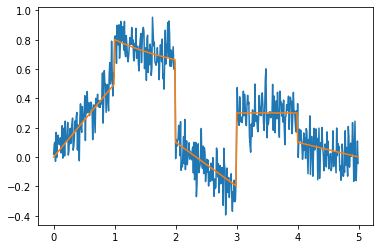

In [116]:
import numpy as np
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
x = np.arange(0,5, 0.01)
n = np.size(x)
one = int(n / 5)
f = np.zeros(x.shape)
f[0:one] = 0.0 + 0.5*x[0:one]
f[(one):2*one] = 0.8 - 0.2*np.log(x[100:200]);
f[(2*one):3*one] = 0.7 - 0.3*x[(2*one):3*one];
f[(3*one):4*one] = 0.3
f[(4*one):(5*one)] = 0.5 - 0.1*x[(4*one):(5*one)];
G = spdiags([-np.ones(n), np.ones(n)], np.array([0, 1]), n-1,n)
etta = 0.1*np.random.randn(np.size(x));
y = f + etta
plt.figure(); plt.plot(x,y); plt.plot(x,f); plt.show()

In [117]:
def IRLS(y,lambd,G):
  GTG= G.T @ G
  d1=np.linalg.inv(2 * np.eye(len(GTG)) + lambd * GTG)
  d2=2*np.eye(len(y)) @ y
  ans=np.dot(d1,d2)
  return ans

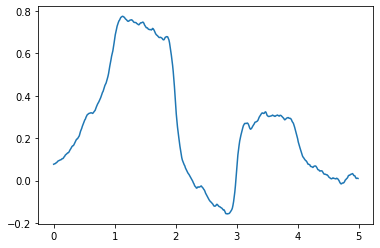

In [118]:
ans = IRLS(y,80,np.array(G.toarray()))
x=np.arange(0,5,0.01)
plt.figure()
plt.plot(x,ans)
plt.show()

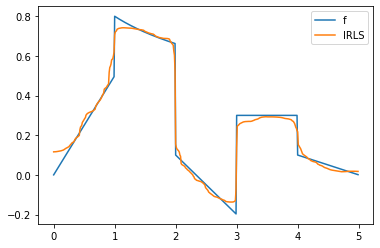

In [119]:
def IRLS10(y,lambd,epsilon,G):
  GTG = G.T @ G
  W=np.eye(len(GTG)-1)
  I=np.eye(len(GTG))
  xk=np.zeros(len(y))
  wk=W
  for i in range(10):
    GTwG=G.T @ wk @G
    xk=np.linalg.inv(I+lambd*GTwG) @ y
    wk=np.diag(1/(abs(G@xk)+epsilon))
  return xk

ansIRLS=IRLS10(y,1,0.001,np.array(G.toarray()))

plt.figure()
plt.plot(x,f)
plt.plot(x,np.asarray(ansIRLS))
plt.legend(['f','IRLS'])
plt.show()


# Question 3

# Imports & data load

In [32]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp
from numpy.linalg import inv, pinv
from numpy.linalg import norm as norm

In [135]:
f = open("Covid-19-USA.txt", "r")
y_obs = f.read().split('\n')
y_obs = list(map(int, y_obs))

# Objective functions

In [136]:
def f(theta,x):
    return theta[0]*exp(-theta[1]*((x-theta[2])**2))

def predict(theta):
    return np.asarray([f(theta,x) for x in range(1,len(y_obs)+1)])

def F(theta):
    return 0.5 * (norm(predict(theta) - y_obs)) ** 2

def f_jacobian(theta):
    X = range(1,100)
    j1 = lambda X,thet: [np.exp(-thet[1]*((x-thet[2])**2)) for x in X]
    j2 = lambda X,thet: [f(thet,x)*(-1)*((x-thet[2])**2) for x in X]
    j3 = lambda X,thet: [f(thet,x)*thet[1]*2*(x-thet[2]) for x in X]
    J = np.array([j1(X,theta),j2(X,theta),j3(X,theta)])
    return J

def F_gradient(theta):
    return f_jacobian(theta) @ (predict(theta) - y_obs)

# GN & SD

In [137]:
def armijo_search(f,grad,d,curr_x,maxIter = 100,alpha0=1):
    alpha = alpha0
    b = 0.5
    c = 10e-3

    for _ in range(maxIter):
        if f(curr_x + alpha * d) <= f(curr_x) + c * alpha * np.dot(grad(curr_x), d):
            return alpha
        else:
            alpha = b * alpha
    return alpha

In [138]:
def gauss_newton(theta,max_iter = 100):
    F_arr = [F(theta)]
    
    for _ in range(max_iter):
        J = f_jacobian(theta).T
        r = predict(theta) - y_obs
       
        grad = np.dot(J.T,r)
        d =  -1 * inv(J.T@J) @ grad
        
        alpha = armijo_search(F, F_gradient, d, theta, 100)
        theta = theta + alpha * d
        F_arr.append(F(theta))
        
        if F(theta) < 10**-3:
            break

    return theta , F_arr

In [139]:
def steepest_descent(theta, max_iter=100):
    F_arr = [F(theta)]

    for _ in range(max_iter):
        alpha = armijo_search(F, F_gradient, -1 * F_gradient(theta), theta, 100)
        theta = theta - (alpha * F_gradient(theta))
        F_arr.append(F(theta))

        if(F(theta) < 10 ** -3):
            break
        
    return theta , F_arr

In [140]:
theta_guess = [1000000, 0.001, 110]
gn_solution , gn_F_arr = gauss_newton(theta_guess,100)
sd_solution, sd_F_arr = steepest_descent(theta_guess)

/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_10262/1506353738.py:2: RuntimeWarning: overflow encountered in exp
  return theta[0]*exp(-theta[1]*((x-theta[2])**2))
/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_10262/1506353738.py:2: RuntimeWarning: overflow encountered in double_scalars
  return theta[0]*exp(-theta[1]*((x-theta[2])**2))


# Convergance graph

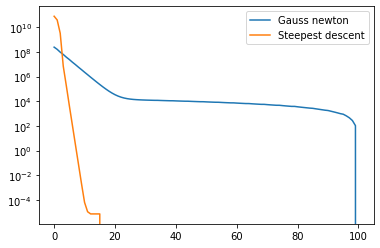

In [141]:
plt.semilogy([np.abs(F(sd_solution)-x) for x in sd_F_arr],label="Gauss newton")
plt.semilogy([np.abs(F(gn_solution)-x) for x in gn_F_arr],label="Steepest descent")
plt.legend()
plt.show()

# Question 4

In [5]:
import numpy as np
from numpy import linalg
import struct
from array import array
from os.path import join
import os
import random
import matplotlib.pyplot as plt

In [33]:
# MNIST Data Loader Class
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            #img = img.reshape(28, 28)
            meanval = np.mean(img)
            stdval = np.std(img)
            img = (img - meanval) / (stdval + 0.1)
            images[i][:] = img
            
        
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  
		
		
#
# Set file paths based on added MNIST Datasets
#
cwd = os.getcwd()
input_path = cwd + "/"
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
    plt.show()
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#



In [34]:
#hide
digits_01 = np.array([0,1])
digits_89 = np.array([8,9])

x_train_10, y_train_10 = zip(*((img, label) for img, label in zip(x_train, y_train) if label in digits_01))
x_train_89, y_train_89 = zip(*((img, label) for img, label in zip(x_train, y_train) if label in digits_89))

x_test_10, y_test_10 = zip(*((img, label) for img, label in zip(x_test, y_test) if label in digits_01))
x_test_89, y_test_89 = zip(*((img, label) for img, label in zip(x_test, y_test) if label in digits_89))

x_train_89 = np.array(x_train_89)
y_train_89 = np.array(y_train_89)

x_test_89 = np.array(x_test_89)
y_test_89 = np.array(y_test_89)

x_train_10 = np.array(x_train_10)
y_train_10 = np.array(y_train_10)

x_test_10 = np.array(x_test_10)
y_test_10 = np.array(y_test_10)

In [35]:
c1_8 = np.where(8 == np.array(y_train_89), 1 , 0)
c1_8_test = np.where(8 == np.array(y_test_89), 1 , 0)
c2_9 = np.where(9 == np.array(y_train_89), 1 , 0)

c1_0 = np.where(0 == np.array(y_train_10), 1 , 0)
c1_0_test = np.where(0 == np.array(y_test_10), 1 , 0)
c2_1 = np.where(1 == np.array(y_train_10), 1 , 0)

# Peek at our data

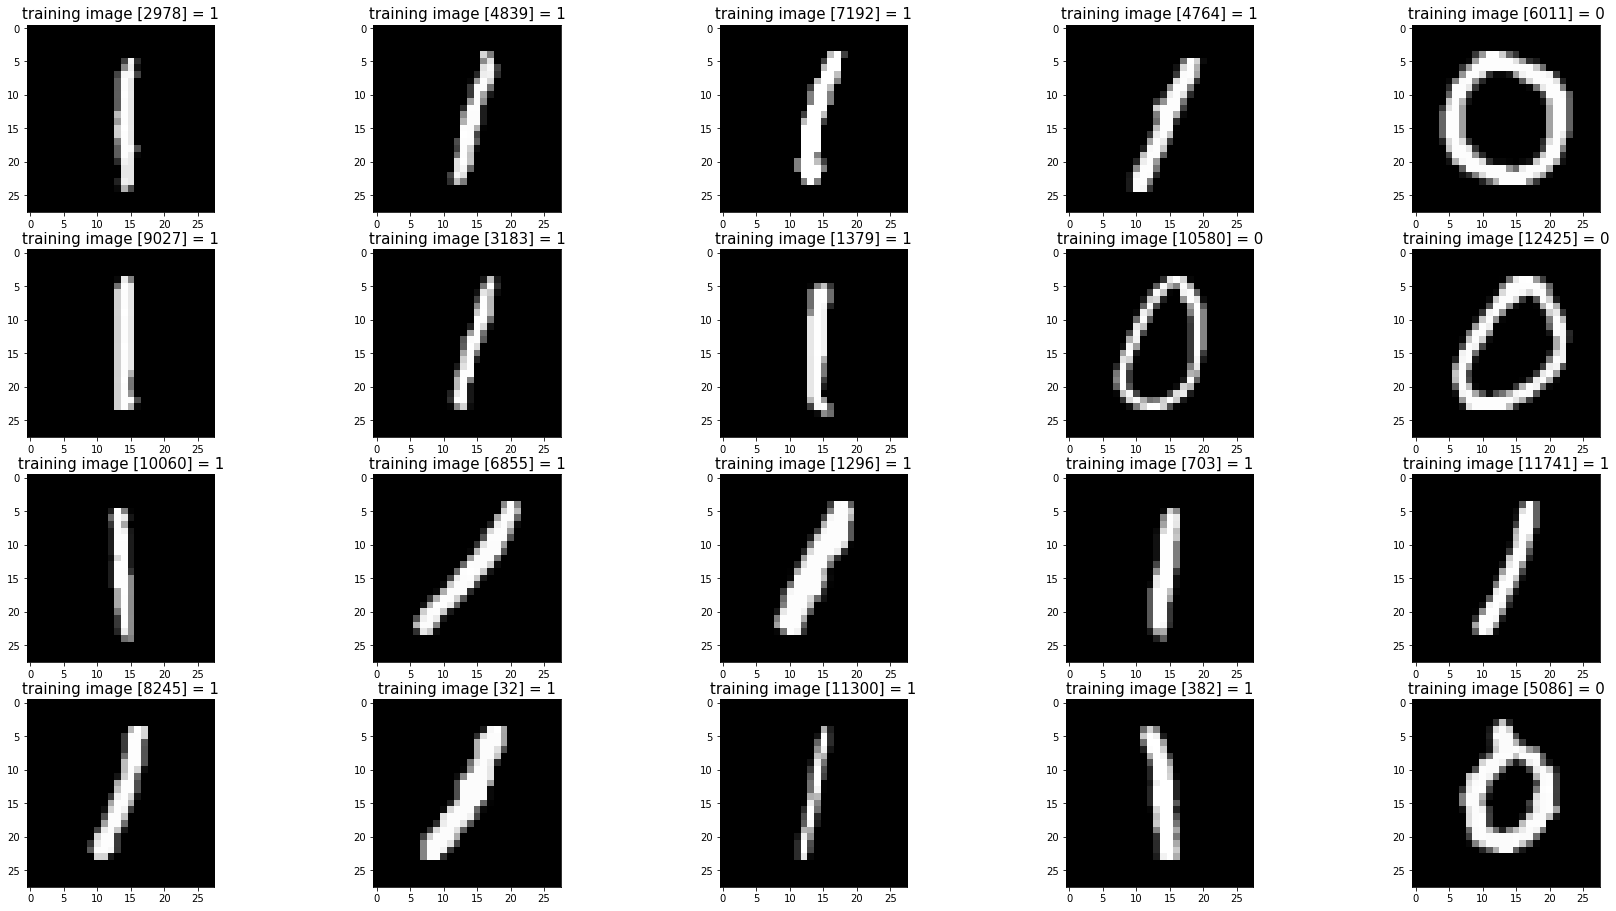

In [36]:
images_2_show = []
titles_2_show = []
sample_size = 20
for i in range(0, sample_size):
    r = random.randint(1, len(x_train_10))
    images_2_show.append(np.array(x_train_10[r]).reshape(28,28))
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_10[r]))    

show_images(images_2_show, titles_2_show)

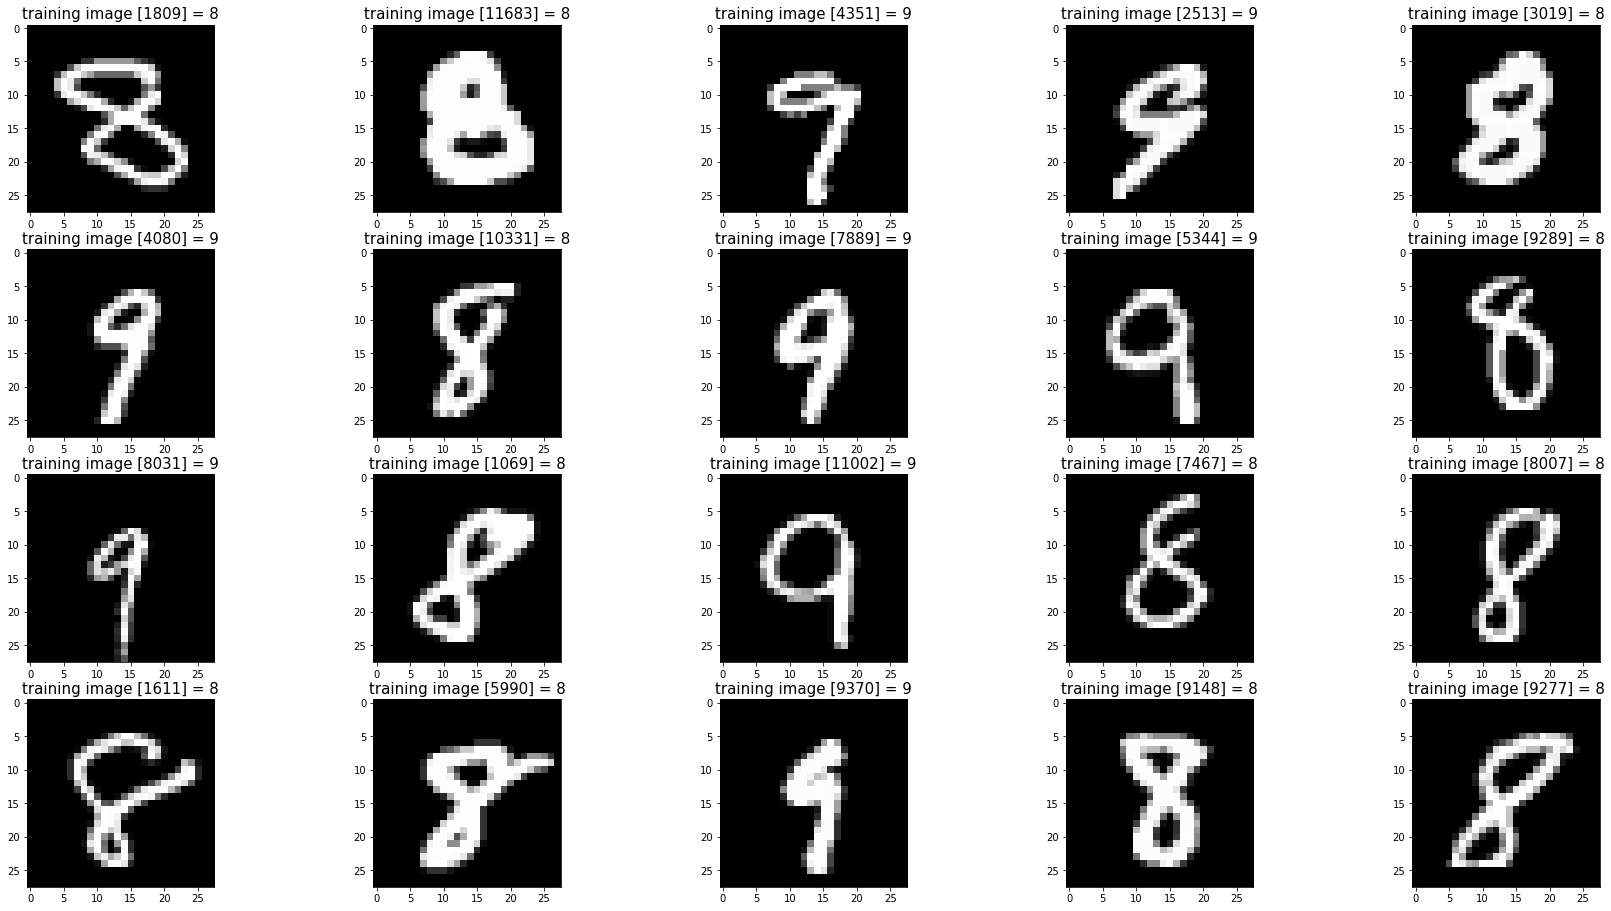

In [37]:
images_2_show = []
titles_2_show = []
sample_size = 20
for i in range(0, sample_size):
    r = random.randint(1, len(x_train_89))
    images_2_show.append(np.array(x_train_89[r]).reshape(28,28))
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train_89[r]))    

show_images(images_2_show, titles_2_show)

# Sigmoid ; Sigmoid inverse ; gradient ; hessian ; Objective function

In [38]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def siginv(y):
  return np.log(y/(1 - y))

def gradient(X,w,b):
  return (1/X.shape[1]) * X.T @ (sigmoid(X @ w) - b)

def hessian(X,w):
  D = np.diag(sigmoid(X @ w) * (1-sigmoid(X @ w)))
  return (1/X.shape[1]) * X.T @ D @ X

  # X @ w ~ b
def F(X,w,b):
  return (-1 / len(X)) * (b @ np.log(sigmoid(X @ w)) + (1-b) @ np.log(1 - sigmoid(X @ w)))

# Gradient Test

In [39]:
#hide
def gradient_test(F,grad_F):
  epsilon = 0.1
  n = 20
  np.random.seed(52)
  x = np.random.rand(n,n)
  w = np.random.rand(n)

  c1 = np.array([1,0]*(int(n/2)))
  c2 = np.array([0,1]*(int(n/2)))
  d = np.random.rand(n)
  F0 = F(x,w,c1)
  g0 = grad_F(x,w,c1)
  iterations = 8
  y0 = np.zeros(iterations)
  y1 = np.zeros(iterations)

  for k in range(iterations):
    epsk = epsilon * pow(0.5,k)
    Fk = F(x + epsk * d,w,c1)
    F1 = F0 + epsk * np.dot(g0,d)

    y0[k] = linalg.norm(Fk - F0)
    y1[k] = linalg.norm(Fk - F1)

  plt.semilogy(y0)
  plt.semilogy(y1)

  plt.xlabel("Iterations")
  plt.ylabel("error")
  plt.title("Gradient test")
  plt.legend(["zero order", "first order"])

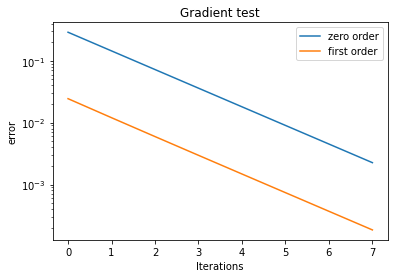

In [40]:
gradient_test(F,gradient)

# Jacobian Test

In [41]:
#hide
def jacobian_test(grad_F,hesian_F):
  epsilon = 0.1
  n = 20
  np.random.seed(52)
  x = np.random.rand(n,n)
  w = np.random.rand(n)

  c1 = np.array([1,0]*(int(n/2)))
  c2 = np.array([0,1]*(int(n/2)))
  d = np.random.rand(n)
  F0 = grad_F(x,w,c1)
  iterations = 8
  y1 = np.zeros(iterations)
  y2 = np.zeros(iterations)

  for k in range(iterations):
    epsk = epsilon * pow(0.5,k)
    Fk = grad_F(x + epsk * d,w,c1)
    F1 = F0 + epsk * np.dot(F0,d)
    F2 = F0 + epsk * d.T  @ hesian_F(x,w) 

    y1[k] = linalg.norm(Fk - F1)
    y2[k] = linalg.norm(Fk - F2)

  plt.semilogy(y1)
  plt.semilogy(y2)

  plt.xlabel("Iterations")
  plt.ylabel("error")
  plt.title("Jacobian test")
  plt.legend(["first order", "second order"])



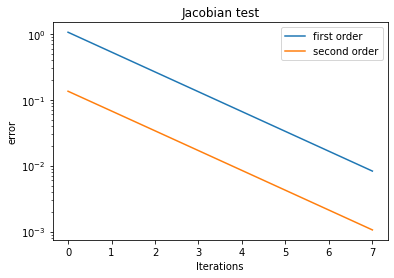

In [42]:
jacobian_test(gradient,hessian)

# Gradient descent

In [79]:
# 0 < beta < 1
# 0 < c < 1
def armijo_search_logistic(f,X,w_k,b,grad,d,maxIter = 1000,alpha0=1):
    alpha = alpha0
    beta = 0.5
    c = 10e-4
    f_w_k = f(X,w_k,b)
    for _ in range(maxIter):
        X = np.array(X)
        if f(X,w_k + alpha * d,b) <= f_w_k + c * alpha * np.dot(grad(X,w_k,b),d):
            return alpha
        else:
            alpha = beta * alpha

def gradient_descent(F,X,w0,b,grad,max_iter):
  F_arr = []
  w = w0

  F_arr.append(F(X, w, b))

  for _ in range(max_iter):
    d =  -1 * grad(X, w, b)

    alpha = armijo_search_logistic(F, X, w, b, grad, d, 100)
    w_next = w + alpha * d
    F_arr.append(F(X, w, b))

    #print(np.abs(F_arr[-1] - F_arr[-2]))
    if len(F_arr)>2 and np.abs(F_arr[-1] - F_arr[-2]) < 10 ** -5:
      print("converged!")
      break;
    #if max(change) <= stop:
      #  print("converged")
        #break
    w = w_next

  return w , F_arr

# Train with gradient descent

In [44]:
w_guess = np.ones(784) # starting with a random guess of weights
n_samples = 30000
x_train_10 = x_train_10[:, :n_samples]
y_train_10 = y_train_10[:n_samples]
c1_8  = c1_8[:n_samples]
x_train_89 = x_train_89[:, :n_samples]
y_train_89 = y_train_89[:n_samples]
c1_0 = c1_0[:n_samples]

In [80]:
optimal_w_89_gd, diff_arr_89 = gradient_descent(F, x_train_89, w_guess, c1_8, gradient, 100)
optimal_w_10_gd, diff_arr_10 = gradient_descent(F, x_train_10, w_guess, c1_0, gradient, 100)

/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_57467/3229467519.py:16: RuntimeWarning: divide by zero encountered in log
  return (-1 / len(X)) * (b @ np.log(sigmoid(X @ w)) + (1-b) @ np.log(1 - sigmoid(X @ w)))
/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_57467/3229467519.py:16: RuntimeWarning: invalid value encountered in matmul
  return (-1 / len(X)) * (b @ np.log(sigmoid(X @ w)) + (1-b) @ np.log(1 - sigmoid(X @ w)))


converged!


/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_57467/3229467519.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


converged!


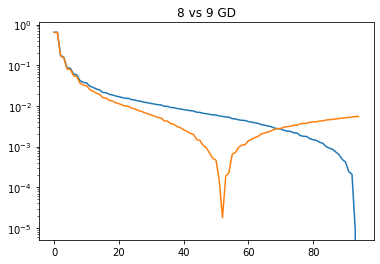

In [81]:
#hide
plt.semilogy([np.abs(F(x_train_89,optimal_w_89_gd,c1_8)-x) for x in diff_arr_89])
plt.semilogy([np.abs(F(x_test_89,optimal_w_89_gd,c1_8_test)-x) for x in diff_arr_89])
plt.title("8 vs 9 GD")
plt.show()


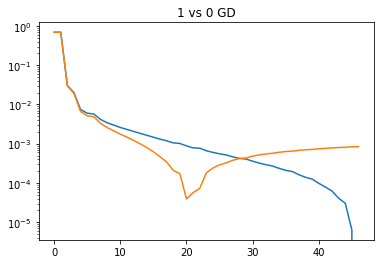

In [82]:
#hide
plt.semilogy([np.abs(F(x_train_10,optimal_w_10_gd,c1_0)-x) for x in diff_arr_10])
plt.semilogy([np.abs(F(x_test_10,optimal_w_10_gd,c1_0_test)-x) for x in diff_arr_10])
plt.title("1 vs 0 GD")
plt.show()

Detect 8/9 model accuracy:  98.0333 %


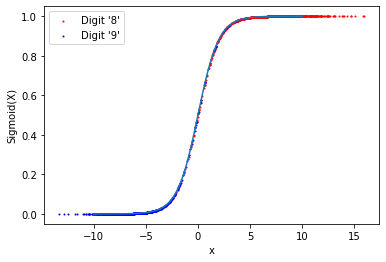

Digit 8 mean:  0.9669
Digit 9 mean:  0.0329


In [83]:
c1 = 8
c2 = 9
sig_dig_8 = []
sig_dig_9 = []

b_predict = sigmoid(x_test_89 @ optimal_w_89_gd)
b_predict_classify_89 = np.where(b_predict > 0.5 ,1 ,0)
model_accuracy = 100 * (c1_8_test == b_predict_classify_89).sum() / len(c1_8_test)

print("Detect 8/9 model accuracy: ", "{:.4f} %".format(model_accuracy))

for predict,real in zip(b_predict, y_test_89):
  if real == c1:
    sig_dig_8.append(predict)

  elif real == c2:
    sig_dig_9.append(predict)

x = np.linspace(-10, 10, 100)
  
plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.scatter([siginv(x) for x in sig_dig_8], sig_dig_8, color = 'red',label="Digit '8'",s=1)
plt.scatter([siginv(x) for x in sig_dig_9], sig_dig_9, color = 'blue',label="Digit '9'",s=1)
plt.legend()
plt.show()

print("Digit 8 mean: ","{:.4f}".format(np.array(sig_dig_8).mean()))
print("Digit 9 mean: ","{:.4f}".format(np.array(sig_dig_9).mean()))

Detect 8/9 model accuracy:  99.9527 %


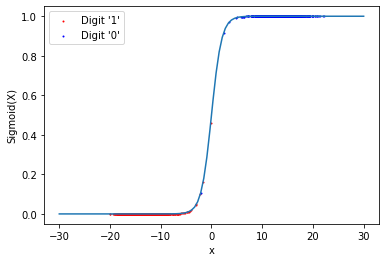

Digit 1 mean:  0.0008
Digit 0 mean:  0.9989


In [85]:
sig_dig_1 = []
sig_dig_0 = []

c1 = 1
c2 = 0
b_predict = sigmoid(x_test_10 @ optimal_w_10_gd)
b_predict_classify_10 = np.where(b_predict > 0.5 ,1 ,0)
model_accuracy = 100 * (c1_0_test == b_predict_classify_10).sum() / len(c1_0_test)

print("Detect 8/9 model accuracy: ", "{:.4f} %".format(model_accuracy))

for predict,real in zip(b_predict, y_test_10):
  if real == c1:
    sig_dig_1.append(predict)

  elif real == c2:
    sig_dig_0.append(predict)

x = np.linspace(-30, 30, 100)
  
plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.scatter([siginv(x) for x in sig_dig_1], sig_dig_1, color = 'red',label="Digit '1'",s=1)
plt.scatter([siginv(x) for x in sig_dig_0], sig_dig_0, color = 'blue',label="Digit '0'",s=1)
plt.legend()
plt.show()

print("Digit 1 mean: ","{:.4f}".format(np.array(sig_dig_1).mean()))
print("Digit 0 mean: ","{:.4f}".format(np.array(sig_dig_0).mean()))

# Exact Newton method

In [102]:
#hide
def newton_method(F,X,w0,b,grad,hessian,max_iter):
  F_arr = []
  w = w0

  F_arr.append(F(X, w, b))

  for _ in range(max_iter):
    d =  -1 * np.linalg.pinv(hessian(X,w)) @ grad(X, w, b)

    alpha = armijo_search_logistic(F, X, w, b, grad, d, 100)
    w_next = w + alpha * d
    F_arr.append(F(X, w, b))

    if len(F_arr)>2 and np.abs(F_arr[-1] - F_arr[-2]) < 10 ** -3:
      break
    w = w_next

  return w , F_arr

In [103]:
optimal_w_89_newton, diff_arr_89_newton = newton_method(F, x_train_89, w_guess, c1_8, gradient,hessian, 100)
optimal_w_10_newton, diff_arr_10_newton = newton_method(F, x_train_10, w_guess, c1_0, gradient,hessian, 100)

/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_57467/3229467519.py:16: RuntimeWarning: divide by zero encountered in log
  return (-1 / len(X)) * (b @ np.log(sigmoid(X @ w)) + (1-b) @ np.log(1 - sigmoid(X @ w)))
/var/folders/yq/mkgzhy8x5jz5z1dtjg0_4b5m0000gn/T/ipykernel_57467/3229467519.py:16: RuntimeWarning: invalid value encountered in matmul
  return (-1 / len(X)) * (b @ np.log(sigmoid(X @ w)) + (1-b) @ np.log(1 - sigmoid(X @ w)))


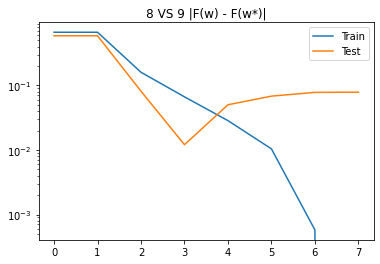

In [104]:
plt.semilogy([np.abs(F(x_train_89,optimal_w_89_newton,c1_8)-x) for x in diff_arr_89_newton], label='Train')
plt.semilogy([np.abs(F(x_test_89,optimal_w_89_newton,c1_8_test)-x) for x in diff_arr_89_newton], label='Test')
plt.legend()
plt.title("8 VS 9 |F(w) - F(w*)|")
plt.show()

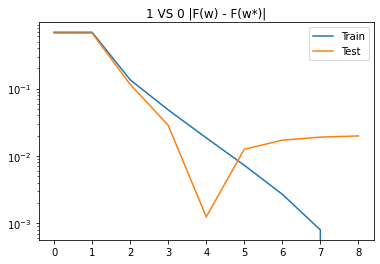

In [105]:
#hide
plt.semilogy([np.abs(F(x_train_10,optimal_w_10_newton,c1_0)-x) for x in diff_arr_10_newton],label = "Train")
plt.semilogy([np.abs(F(x_test_10,optimal_w_10_newton,c1_0_test)-x) for x in diff_arr_10_newton], label= "Test")
plt.legend()
plt.title("1 VS 0 |F(w) - F(w*)|")
plt.show()

Detect 8/9 model accuracy:  97.0751 %


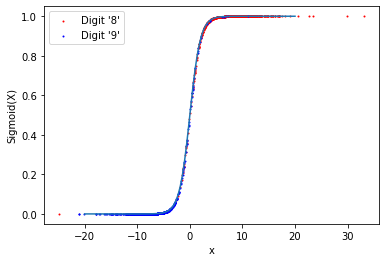

Digit 8 mean:  0.9612
Digit 9 mean:  0.0352


In [115]:
c1 = 8
c2 = 9
sig_dig_8 = []
sig_dig_9 = []

b_predict = sigmoid(x_test_89 @ optimal_w_89_newton)
b_predict_classify_89 = np.where(b_predict > 0.5 ,1 ,0)
model_accuracy = 100 * (c1_8_test == b_predict_classify_89).sum() / len(c1_8_test)

print("Detect 8/9 model accuracy: ", "{:.4f} %".format(model_accuracy))

for predict,real in zip(b_predict, y_test_89):
  if real == c1:
    sig_dig_8.append(predict)

  elif real == c2:
    sig_dig_9.append(predict)

x = np.linspace(-20, 20, 100)
  
plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.scatter([siginv(x) for x in sig_dig_8], sig_dig_8, color = 'red',label="Digit '8'",s=1)
plt.scatter([siginv(x) for x in sig_dig_9], sig_dig_9, color = 'blue',label="Digit '9'",s=1)
plt.legend()
plt.show()

print("Digit 8 mean: ","{:.4f}".format(np.array(sig_dig_8).mean()))
print("Digit 9 mean: ","{:.4f}".format(np.array(sig_dig_9).mean()))

Detect 8/9 model accuracy:  99.9054 %


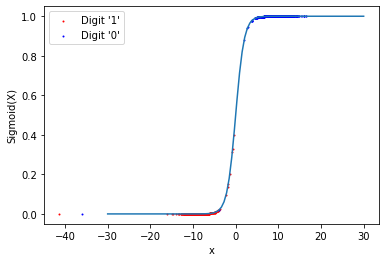

Digit 1 mean:  0.0019
Digit 0 mean:  0.9973


In [107]:
sig_dig_1 = []
sig_dig_0 = []

c1 = 1
c2 = 0
b_predict = sigmoid(x_test_10 @ optimal_w_10_newton)
b_predict_classify_10 = np.where(b_predict > 0.5 ,1 ,0)
model_accuracy = 100 * (c1_0_test == b_predict_classify_10).sum() / len(c1_0_test)

print("Detect 8/9 model accuracy: ", "{:.4f} %".format(model_accuracy))

for predict,real in zip(b_predict, y_test_10):
  if real == c1:
    sig_dig_1.append(predict)

  elif real == c2:
    sig_dig_0.append(predict)

x = np.linspace(-30, 30, 100)
  
plt.plot(x, sigmoid(x))
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")

plt.scatter([siginv(x) for x in sig_dig_1], sig_dig_1, color = 'red',label="Digit '1'",s=1)
plt.scatter([siginv(x) for x in sig_dig_0], sig_dig_0, color = 'blue',label="Digit '0'",s=1)
plt.legend()
plt.show()

print("Digit 1 mean: ","{:.4f}".format(np.array(sig_dig_1).mean()))
print("Digit 0 mean: ","{:.4f}".format(np.array(sig_dig_0).mean()))